In [8]:
import tensorflow as tf
import pandas as pd
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import cv2

In [9]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0],28,28,1).astype('float32')/255
X_test = X_test.reshape(X_test.shape[0],28,28,1).astype('float32')/255

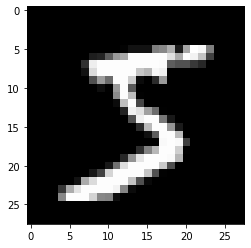

In [10]:
plt.imshow(X_train[0,:,:,0],cmap='gray')

In [11]:
Y_train = to_categorical(Y_train,num_classes = 10)
Y_test = to_categorical(Y_test,num_classes = 10)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=2022)


In [12]:
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),input_shape=(28,28,1),
          activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Conv2D(64,(3,3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=2,padding='same'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_1 (Dense)             (None, 10)               

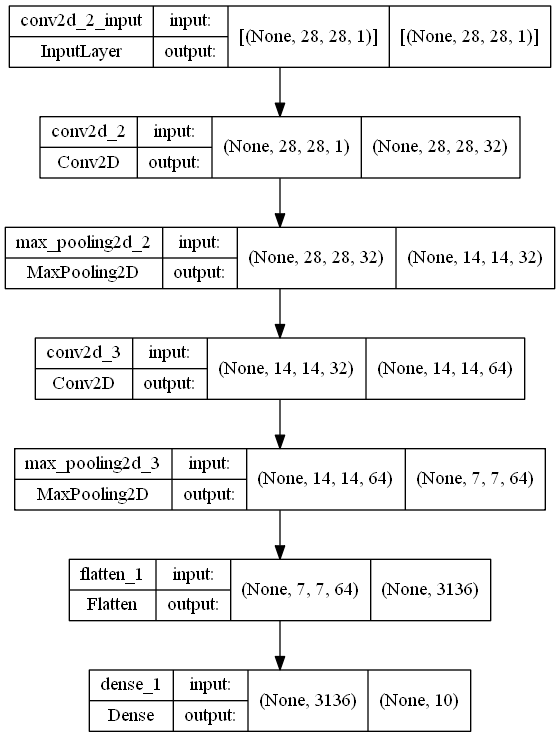

In [13]:
model.compile(loss='categorical_crossentropy',
             optimizer=Adam(learning_rate=5E-04),
             metrics=['accuracy', tf.keras.metrics.AUC(),tf.keras.metrics.Precision()])

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=3, verbose=1, mode='auto',
    baseline=None, restore_best_weights=True
)
model.summary()
plot_model(model, show_shapes=True)

In [14]:
history = model.fit(X_train, Y_train, epochs=50, batch_size=64, callbacks = [es],validation_data=(X_val, Y_val))

Epoch 1/50
750/750 [==============================] - 45s 60ms/step - loss: 0.3139 - accuracy: 0.9112 - auc_1: 0.9935 - precision_1: 0.9537 - val_loss: 0.1155 - val_accuracy: 0.9670 - val_auc_1: 0.9979 - val_precision_1: 0.9724
Epoch 2/50
750/750 [==============================] - 45s 60ms/step - loss: 0.0918 - accuracy: 0.9723 - auc_1: 0.9986 - precision_1: 0.9775 - val_loss: 0.0785 - val_accuracy: 0.9778 - val_auc_1: 0.9985 - val_precision_1: 0.9804
Epoch 3/50
750/750 [==============================] - 45s 60ms/step - loss: 0.0655 - accuracy: 0.9803 - auc_1: 0.9991 - precision_1: 0.9834 - val_loss: 0.0757 - val_accuracy: 0.9778 - val_auc_1: 0.9986 - val_precision_1: 0.9802
Epoch 4/50
750/750 [==============================] - 44s 59ms/step - loss: 0.0543 - accuracy: 0.9833 - auc_1: 0.9993 - precision_1: 0.9857 - val_loss: 0.0632 - val_accuracy: 0.9812 - val_auc_1: 0.9988 - val_precision_1: 0.9833
Epoch 5/50
750/750 [==============================] - 45s 60ms/step - loss: 0.0459 - acc

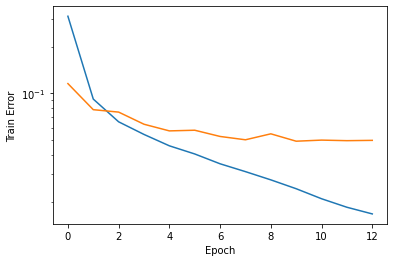

In [15]:

pd.Series(history.history['loss']).plot(logy=True)
pd.Series(history.history['val_loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.savefig("train_error.png")
plt.show()

In [16]:
model.save("model.h5")

In [22]:
model = load_model('model.h5')

In [23]:
print("\n Test Accuracy: %4f"%(model.evaluate(X_test, Y_test)[1]))

313/313 [==============================] - 3s 7ms/step - loss: 0.0413 - accuracy: 0.9891 - auc_6: 0.9987 - precision_5: 0.9895

 Test Accuracy: 0.989100


10


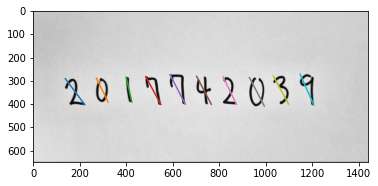

In [25]:
img = plt.imread("2017742039.jpg")
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray_img,cmap='gray')

ret, img_th = cv2.threshold(gray_img, 90,255, cv2.THRESH_BINARY_INV)
contours, hierachy = cv2.findContours(img_th.copy(),cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

rects = [cv2.boundingRect(each) for each in contours]
rects = sorted(rects)
print(len(rects))

for i in rects:  
  plt.plot([i[0],i[2]+i[0]],[i[1],i[3]+i[1]])

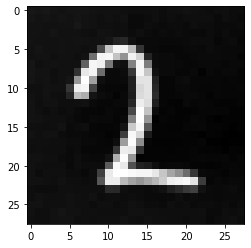

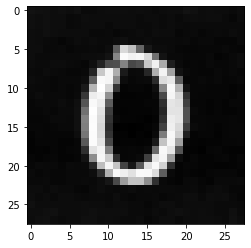

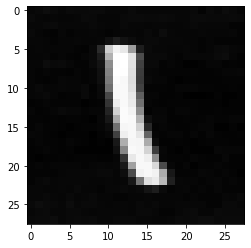

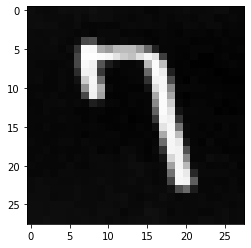

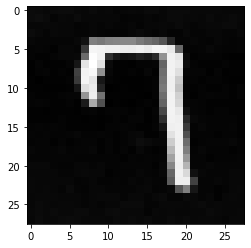

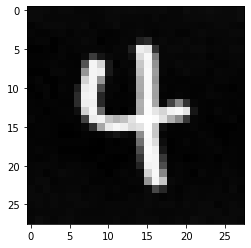

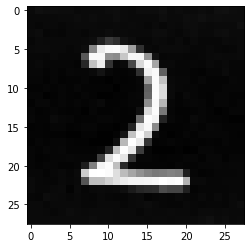

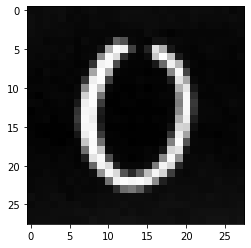

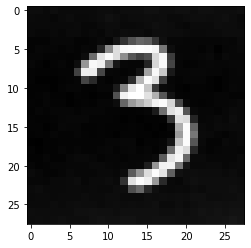

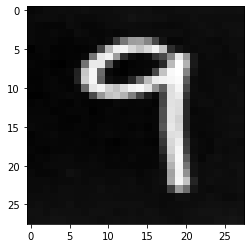

In [26]:
img_list = []
margin = 30
for i in rects:
  num_img= (255-gray_img[i[1]-margin:i[1]+i[3]+margin,i[0]-margin:i[0]+i[2]+margin])
  border_size = max(len(num_img[0,:]),len(num_img[:,1]))
  resized = cv2.resize(num_img,dsize=(28,28),interpolation=cv2.INTER_AREA)

  img_list.append(resized)
  plt.figure()
  plt.imshow(resized,cmap = 'gray')

In [27]:
onehot_vector = []
result_str = []
for i in img_list:
  img = i.reshape(-1, 28, 28, 1).astype('float32')/255
  res=model.predict(img)
  onehot_vector.append(res)
  res = np.argmax(model.predict(img), axis = -1)
  result_str.append(str(res[0]))
  
# print(onehot_vector)
print(np.round(onehot_vector,3))
print(''.join(result_str))

[[[0.    0.001 0.998 0.    0.    0.    0.    0.    0.001 0.   ]]

 [[1.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]]

 [[0.    0.994 0.    0.002 0.    0.003 0.    0.    0.001 0.   ]]

 [[0.    0.001 0.001 0.    0.    0.    0.    0.998 0.    0.   ]]

 [[0.    0.001 0.009 0.    0.005 0.    0.    0.973 0.    0.012]]

 [[0.    0.    0.    0.    1.    0.    0.    0.    0.    0.   ]]

 [[0.    0.    1.    0.    0.    0.    0.    0.    0.    0.   ]]

 [[1.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]]

 [[0.    0.    0.    1.    0.    0.    0.    0.    0.    0.   ]]

 [[0.    0.    0.    0.008 0.    0.    0.    0.06  0.001 0.931]]]
2017742039
